**Confidence Intervals & The Bootstrap**



# Section 1

### Part 1



In [1]:
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import pandas as pd

def confidence_interval(data):
    '''
    Function to compute confidence interval (ci).
    
    Inputs:
    data - ndarray.  Data to be used to compute the interval
    
    Outputs:
    estimated_mean - float.  The mean of the data
    bounds - array. An array of length 2 where bounds[0] is the lower bound and bounds[1] is the upper bound for the ci.
    '''
    n = data.size
    t_quantile = t.ppf(1-0.05/2, df=n-1)
    estimated_mean = data.mean()
    estimated_se = data.std()/np.sqrt(data.size)
    bounds = estimated_mean + t_quantile*estimated_se*np.array([-1,1])
    
    return estimated_mean, bounds

### Part 2

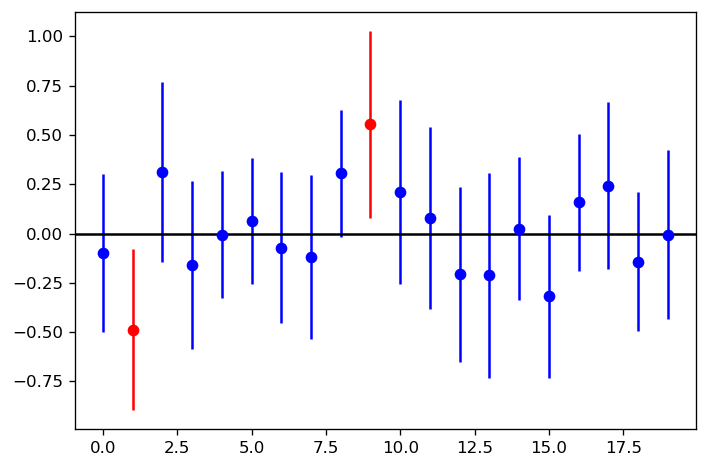

In [2]:
def ci_simulation():
    np.random.seed(3)
    fig, ax = plt.subplots(dpi = 120)
    ax.axhline(0, color = 'k')
    
    for i in range(20):
        data = np.random.normal(size = 25)
        mu,bounds = confidence_interval(data)
        
        color = 'blue'
        if (min(bounds)>0)|(max(bounds)<0):
            color = 'red'

        interval_len = 1.0/2*(bounds[1] - bounds[0])

        ax.errorbar(i, mu, yerr=interval_len, color = color, fmt = 'o')
        
        plt.tight_layout()
        plt.savefig('ci_simulation.png')

    return None

ci_simulation()

### Part 3

1) I expected one interval. 5% of 20 is 1, so I expect 1 of the intervals to be wrong.

2) Random sampling explains the differenc between the number of observed and expected red intervals

### Part 4




In [4]:
def num_propper_length(n=1600):
    '''
    Function to simulate how many confidence intervals would be no longer than 0.1 units long if
    we sampled n observatiosn from a standard normal.
    
    Inputs:
        n - int.  Number of draws to make from the standard normal
        
    Outputs:
        prop_long_enough - float (between 0 and 1).  Proportion of consutrcuted intervals which are no longer than 0.1.
    '''
    np.random.seed(0)
    data = np.random.normal(size = (1000,n))
    ci_length = np.zeros(data.shape[0])
    
    for i,d in enumerate(data):
        _, bounds = confidence_interval(d)
        ci_length[i] = bounds[1] - bounds[0]

    prop_long_enough = np.sum(ci_length<=0.1)    

    return prop_long_enough

### Part 5

When we are calculationg (for example using the formula mentioned above for finding sample size), we use standard deviation=1 and mean=0, because we suppose we are using the normal distribution. But in fact all of the samples of size 1600 might not be distributed normally which means that their mean might not be exactly 0 and their standard deviation might not be exactly 1. Actually I checked the mean and standard deviation of those confidence intervals which were longer than 0.1 and it was exactly the case, (their mean are so close but not equal to 0 and their standard deviation is so close but not equal to 1). 

---

## Section 2

### Part 1


In [5]:
df_train=pd.read_csv('hockey_draftees_train.csv')

model = sm.ols('wt ~ age + ht', data = df_train).fit()

### Part 2


In [6]:
print('Training rsquared is ',model.rsquared)

Training rsquared is  0.31407479140429073


### Part 3

In [7]:
df_test=pd.read_csv('hockey_draftees_test.csv')

y = df_test.wt.values
yhat = model.predict(df_test).values

rsquared_oos = 1 - (np.sum(np.power(y - yhat,2)) / np.sum(np.power(y - y.mean(),2)))

print('Out of sample rsquared is ', rsquared_oos)


Out of sample rsquared is  0.33131985665146646


### Part 4

In [8]:
def bootstrap(data, model, numboot):
    '''
    Function to bootstrap the r-squared for a linear model
    
    Inputs:
        data - dataframe.  Data on which model can predict.
        model - statsmodel ols.  Linear model of weight explained by height and age.  Can predict on data.
        numboot - int.  Number of bootstrap replications.
    
    Outputs:
        bootstrapped_rsquared - array.  An array of size (numboot, ) which contains oos bootstrapped rsquared values.
    
    '''
    bootstrapped_rsquared = np.zeros(numboot)
    for i in range(numboot):
        df_bootstrapped = data.sample(data.shape[0], replace = True)
        
        y = df_bootstrapped.wt.values
        yhat = model.predict(df_bootstrapped).values
        bootstrapped_rsquared[i] = 1 - (np.sum(np.power(y - yhat,2)) / np.sum(np.power(y - y.mean(),2)))

    return bootstrapped_rsquared


### Part 5


(array([   8.,  118.,  467., 1506., 2643., 2790., 1739.,  608.,  109.,
          12.]),
 array([0.23796345, 0.25606341, 0.27416337, 0.29226333, 0.31036329,
        0.32846325, 0.34656321, 0.36466317, 0.38276313, 0.40086309,
        0.41896305]),
 <a list of 10 Patch objects>)

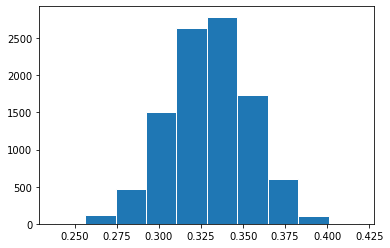

In [9]:
bs_replicates = bootstrap(df_test, model, 10_000)

plt.hist(bs_replicates, edgecolor = 'white')

### Part 6


In [11]:
ci_lower, ci_upper = np.quantile(bs_replicates, [0.025, 0.975])

print('The confidence interval is between', ci_lower, ' and ', ci_upper)

The confidence interval is between 0.2824005745315218  and  0.37647612388451035
